In [32]:
import xgboost as xgb ## XGBoost 불러오기
from xgboost import plot_importance ## Feature Importance를 불러오기 위함
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score
import warnings
warnings.filterwarnings('ignore')

In [13]:
data_merge = pd.read_csv("C:\\Users\\asus\\BigContest\\files\\data_preprocessing\\ver_1_merge_data.csv")
data_merge

,base_date,emd_cd,korean,long_term_frgn,short_term_frgn,resident,card_cnt,card_amt,waste_cnt,waste_amt
0,2019-11-30,50110250,7.321788e+06,469689.3527,129161.4006,25149,267.380645,9586590.265,620,2279550
1,2019-12-31,50110250,6.915173e+06,482920.2385,122124.6609,25080,266.814465,9621756.255,8178,31493650
2,2020-01-31,50110250,7.476137e+06,587299.9640,112758.3034,25076,257.604430,9648302.136,13042,49632850
3,2020-02-29,50110250,5.561978e+06,559439.3959,60252.7989,25021,249.621160,8760701.457,12264,46197050
4,2020-03-31,50110250,6.094369e+06,714445.0812,29661.4429,24942,261.877023,8979547.945,14316,52561750
...,...,...,...,...,...,...,...,...,...,...
1629,2021-02-28,50130620,4.321265e+06,109325.4866,280.6159,4173,65.216000,2463788.712,4563,15566250
1630,2021-03-31,50130620,4.744309e+06,118258.8891,1475.8404,4178,67.700000,2572585.700,4920,17300600
1631,2021-04-30,50130620,5.236706e+06,129227.7480,1283.0997,4161,68.642336,2473174.901,5256,17646850
1632,2021-05-31,50130620,5.805413e+06,144213.2650,1212.2652,4178,69.333333,2864493.949,6346,19494750


xgboost 모델링

In [14]:
X_features = data_merge.loc[:, ['korean', 'long_term_frgn', 'short_term_frgn', 'resident', 'card_cnt', 'card_amt', 'waste_cnt']]
y_label = data_merge.loc[:, 'waste_amt']

In [15]:
# 전체 데이터셋을 학습용 80%, 테스트용 20%로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)
print(X_train.shape, X_test.shape)

(1307, 7) (327, 7)


In [16]:
# 넘파이 형태의 학습 데이터 세트와 테스트 데이터를 DMatrix로 변환하는 예제
dtrain = xgb.DMatrix(data=X_train, label = y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

In [21]:
# max_depth = 3, 학습률은 0.1, 목적함수(objective)는 reg:linear(회귀)
# 오류함수의 평가성능지표는 rmse
# 부스팅 반복횟수는 400
# 조기중단을 위한 최소 반복횟수는 100

params = {'max_depth' : 7,
          'min_child_weight' : 1,
         'eta' : 0.1, 
          'subsample' : 1,
          'colsample_bytree' : 1,
         'objective' : 'reg:linear',
         'eval_metric' : 'rmsle',
         'early_stoppings' : 10 }
num_rounds = 100

In [22]:
# train 데이터 세트는 'train', evaluation(test) 데이터 세트는 'eval' 로 명기
wlist = [(dtrain, 'train'), (dtest,'eval')]
# 하이퍼 파라미터와 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params = params, dtrain=dtrain, num_boost_round=num_rounds, evals=wlist)

[01:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:48:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-rmsle:2.31350	eval-rmsle:2.31652
[1]	train-rmsle:1.67178	eval-rmsle:1.67360
[2]	train-rmsle:1.31567	eval-rmsle:1.31465
[3]	train-rmsle:1.07783	eval-rmsle:1.07869
[4]	train-rmsle:0.90266	eval-rmsle:0.90313
[5]	train-rmsle:0.76876	eval-rmsle:0.77086
[6]	train-rmsle:0.66169	eval-rmsle:0.66422
[7]	train-rmsle:0.57491	eval-rmsle:0.57896
[8]	train-rmsle:0.50256	eval-rmsle:0.50764
[9]	train-rmsle:0.44178	eval-rmsle:0.4476

In [23]:
gridsearch_params = [(max_depth, min_child_weight)
                    for max_depth in range(1,4)
                    for min_child_weight in range(17,21)]

In [27]:
rmsle_min = float("Inf")
best_params = None

for max_depth, min_child_weight in gridsearch_params:
    
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    
    xg_cvresults = xgb.cv(params, dtrain = dtrain, num_boost_round = 100,
                      seed = 0, nfold=10, metrics = {'rmsle'}, early_stopping_rounds = 10,)
    
    rmsle_mean = xg_cvresults['test-rmsle-mean'].min()
    
    print("max_depth: {} | min_child_weight: {} with rmsle: {:.3}\n".format(max_depth,min_child_weight,rmsle_mean))
    
    if rmsle_mean < rmsle_min:
        rmsle_min = rmsle_mean
        best_params = (max_depth, min_child_weight)

        
print("Best Parameters: max_depth: {} | min_child_weight: {} with rmsle: {:.3f}". format(best_params[0], 
                                                                                  best_params[1], rmsle_min))

[01:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

max_depth: 1 | min_child_weight: 18 with rmsle: 0.262

[01:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some p

max_depth: 1 | min_child_weight: 20 with rmsle: 0.262

[01:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some p

max_depth: 2 | min_child_weight: 18 with rmsle: 0.191

[01:49:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:49:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some p

max_depth: 2 | min_child_weight: 20 with rmsle: 0.19

[01:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some pa

max_depth: 3 | min_child_weight: 18 with rmsle: 0.165

[01:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:49:39] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some p

max_depth: 3 | min_child_weight: 20 with rmsle: 0.165

Best Parameters: max_depth: 3 | min_child_weight: 17 with rmsle: 0.161


In [28]:
params['max_depth'] = 2
params['min_child_weight'] = 19

In [29]:
gridsearch_params = [
    (subsample, colsample)
    for subsample in [i/10. for i in range(7,11)]
    for colsample in [i/10. for i in range(1,5)]
]

In [30]:
rmsle_min = float("Inf")
best_params = None

for subsample, colsample in (gridsearch_params):
    
    params['subsample'] = subsample
    params['colsample_bytree'] = colsample
    
    xg_cvresults = xgb.cv(params, dtrain = dtrain, num_boost_round = 100,
                      seed = 0, nfold=10, metrics = {'rmsle'}, early_stopping_rounds = 10,)
    
    logloss_mean = xg_cvresults['test-rmsle-mean'].min()
    
    print("subsample: {} | colsample: {} with rmsle: {:.3f}\n".format(subsample,colsample,rmsle_mean))
    
    if rmsle_mean < rmsle_min:
        rmsle_min = rmsle_mean
        best_params = (subsample, colsample)
        
print("Best Parameters: subsample: {} | colsample: {} with rmsle: {:.3f}". format(best_params[0], 
                                                                           best_params[1], rmsle_min))

[01:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  pass

subsample: 0.7 | colsample: 0.2 with rmsle: 0.165

[01:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 0.7 | colsample: 0.4 with rmsle: 0.165

[01:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:26] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 0.8 | colsample: 0.2 with rmsle: 0.165

[01:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 0.8 | colsample: 0.4 with rmsle: 0.165

[01:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:31] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 0.9 | colsample: 0.2 with rmsle: 0.165

[01:51:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 0.9 | colsample: 0.4 with rmsle: 0.165

[01:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 1.0 | colsample: 0.2 with rmsle: 0.165

[01:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
[01:51:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "early_stoppings" } might not be used.

  This may not be accurate due to some param

subsample: 1.0 | colsample: 0.4 with rmsle: 0.165

Best Parameters: subsample: 0.7 | colsample: 0.1 with rmsle: 0.165


feature importance 시각화

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

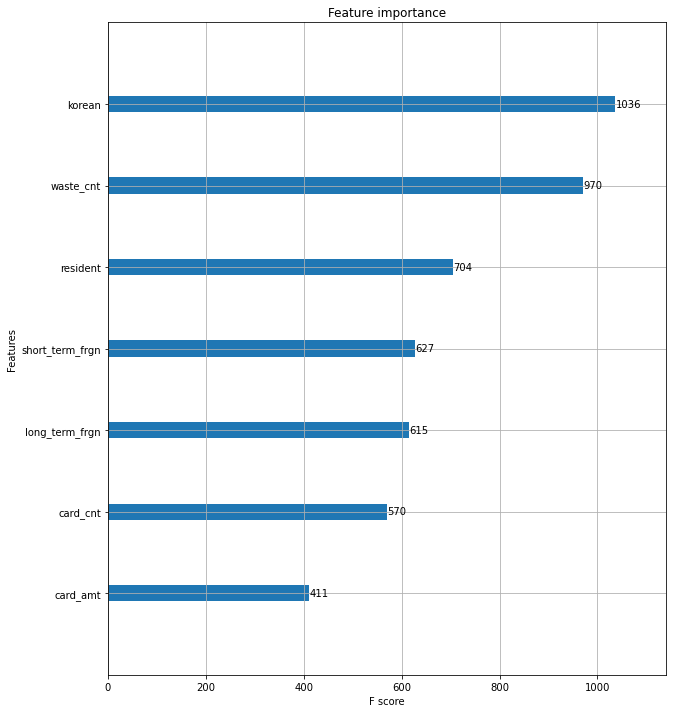

In [31]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)